# Example of omniscidb UDF/UDTF: Black-Scholes Model

The aim of this notebook is to demonstrate how one can enhance OmniSciDB capabilities with UDF (User-Defined Functions) and UDTF (User-Defined Table Functions). For that end, we will demonstrate how one can create, register and invoke UDFs/UDTFs using [RBC](https://github.com/xnd-project/rbc) and [Numba](https://github.com/numba/numba).

## Black-Scholes Model

The Black-Scholes model describes the price of an option over time. 

$C(S_t, t) = N(d_1)S - N(d_2)PV(K)$

$d_1 = \frac{1}{\sigma \sqrt{T - t}} [\ln(\frac{S}{K}) + (r + \frac{\sigma^2}{2}) + (T - t)]$

$d_2 = d_1 - \sigma \sqrt{T-t}$

$PV(K) = Ke^{-r(T-t)}$

Where
* $N$ is the [cummulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function)
* $T-t$ is the time to maturity
* $S$ is the [spot price](https://en.wikipedia.org/wiki/Spot_price)
* $K$ is the strike price
* $r$ is the [risk-free rate](https://en.wikipedia.org/wiki/Risk_free_rate)
* $\sigma$ is the [volatity](https://en.wikipedia.org/wiki/Volatility_(finance)) of returns of the underlying asset

## Connecting to the OmniSciDB server

Let's establish a connection to the OmniSciDB server

In [1]:
import warnings; warnings.filterwarnings('ignore')

In [2]:
from rbc.omniscidb import RemoteOmnisci
omnisci = RemoteOmnisci(user='admin', password='HyperInteractive',
                     host='127.0.0.1', port=6274, dbname='omnisci')
print(f'Connecting to OmnisciDB version {omnisci.version}')
assert omnisci.version[:3] >= (5, 4, 0), omnisci.version

Connecting to OmnisciDB version (5, 4, 0, 'dev-20200824-5b46cd667f')


This notebook requires OmnisciDB version 5.4 or newer. If the above fails or one is connected to older version of OmnisciDB, please resolve the issue before continuing.

## Test Data

For this notebook, we will simulate a financial model called [black-scholes](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model). For that, we will be using data from the following website:
- http://www.scientific-consultants.com/nnbd.html

Read and adjust the test data

In [8]:
import pandas as pd

# Data taken from
# http://www.scientific-consultants.com/nnbd.html
df = pd.read_csv('data_black_scholes.csv', sep=',')
df['S'] = 100.0
df['r'] = 0.0
df['TIME'] = df['TIME'] / 252
df.tail()

,FCTNO,VLTY,TIME,STRIKE,OPRICE,S,r
1525,1526,2.0,0.059524,121.0,12.3662,100.0,0.0
1526,1527,2.0,0.059524,122.0,12.1061,100.0,0.0
1527,1528,2.0,0.059524,123.0,11.8515,100.0,0.0
1528,1529,2.0,0.059524,124.0,11.6021,100.0,0.0
1529,1530,2.0,0.059524,125.0,11.3580,100.0,0.0


### Create a table named "black_scholes" in the database

In [10]:
SQL=lambda query: list(omnisci.sql_execute(query)[1])
SQL('drop table if exists black_scholes')
SQL('create table if not exists black_scholes ('
    ' S DOUBLE, X DOUBLE, T DOUBLE, r DOUBLE,'
    ' sigma DOUBLE, OPRICE DOUBLE);')
print('create table "black_scholes"')

create table "black_scholes"


Insert data into the database

In [11]:
S = df['S']
X = df['STRIKE']
T = df['TIME']
r = df['r']
sigma = df['VLTY']
OPRICE = df['OPRICE']
omnisci.load_table_columnar('black_scholes', S=S, X=X, T=T, r=r, sigma=sigma, OPRICE=OPRICE)

Verify that the table **black_scholes** contains the data

In [12]:
result = SQL('SELECT X, T, sigma, OPRICE FROM black_scholes;')
df2 = pd.DataFrame(result, columns=['STRIKE', 'TIME', 'VLTY', 'OPRICE'])
df2.tail()

,STRIKE,TIME,VLTY,OPRICE
1525,121.0,0.059524,2.0,12.3662
1526,122.0,0.059524,2.0,12.1061
1527,123.0,0.059524,2.0,11.8515
1528,124.0,0.059524,2.0,11.6021
1529,125.0,0.059524,2.0,11.3580


In [13]:
result = SQL('SELECT COUNT(*) FROM black_scholes;')
print(f'Number of rows: {result[0]}')

Number of rows: (1530,)


## Why use UDF/UDTF?

For large datasets, retrieving the data from the server might not be viable due to hardware and/or network limitation. In those cases, makes sense to do the computation in the server rather than locally.

OmnisciDB server v5.4 implements support for users to define UDFs and UDTFs. The former applies a function to a table data row-by-row while the latter is applied to an entire column.

The UDFs and table functions can be defined as Python functions using the [RBC](https://github.com/xnd-project/rbc/) tool that exploits [Numba](https://github.com/numba/numba) to convert Python functions to [LLVM intermediate representation](https://en.wikipedia.org/wiki/LLVM) and these are registered in the OmnisciDB server.

## Compute the black-scholes model remotely using OmnisciDB UDFs

The following cells will register a function to be called from inside omniscidb

In [14]:
import numba
import math
from rbc import omnisci_backend as np

The `@numba.njit` decorator register the `cnd_numba` function so that it can be called by other UDFs/UDTFs functions

In [15]:
@numba.njit
def cnd_numba(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * math.fabs(d))
    ret_val = (RSQRT2PI * math.exp(-0.5 * d * d) *
               (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5))))))
    if d > 0:
        ret_val = 1.0 - ret_val
    return ret_val

Register the UDT function as a new SQL function in OmnisciDB server. Notice the `@omnisci` decorator takes the signature of the function as argument:
- `@omnisci(signature)` or
- `@omnisci([list_of_signatures])`

In the example below, `black_scholes_UDT` accepts five `double`s an returns a `double`.

In [77]:
# register a UDTF as a new SQL function in OmnisciDB server 
@omnisci('double(double, double, double, double, double)')
def black_scholes_UDF(S, X, T, r, sigma):
    d1 = (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    cndd1 = cnd_numba(d1)
    cndd2 = cnd_numba(d2)

    expRT = math.exp((-1. * r) * T)
    
    callResult = (S * cndd1 - X * expRT * cndd2)
    return callResult

Call the UDF function in OmnisciDB sql query

In [78]:
result = SQL('SELECT OPRICE,'
             ' black_scholes_UDF(S, X, T, r, sigma) FROM black_scholes;')

for expected, output in result[:5]:
    print(f'Expected = {expected:.2f}, UDF Model output = {output:.2f}')

Expected = 25.00, UDF Model output = 25.00
Expected = 24.00, UDF Model output = 24.00
Expected = 23.00, UDF Model output = 23.00
Expected = 22.00, UDF Model output = 22.00
Expected = 21.00, UDF Model output = 21.00


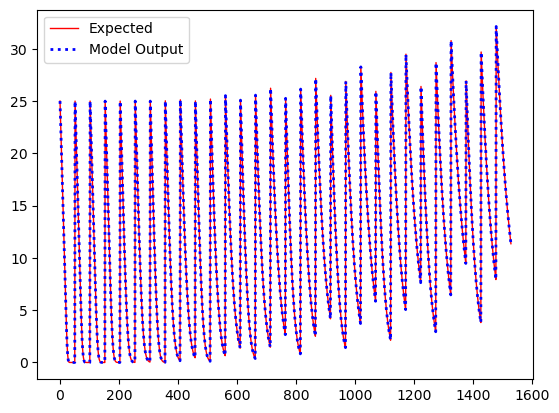

In [83]:
from matplotlib import pyplot as plt

plt.plot(df['OPRICE'], linewidth=1, color='red', label='Expected')
plt.plot(flatten(result), linewidth=2, color='blue', linestyle=':', label='Model Output')
plt.legend(loc="upper left")
plt.show()

As expected, the model was computed in the server using the code in `black_scholes_UDF` 

## Compute the black-scholes model remotely using OmnisciDB UDTFs

In a UDTF function, a column argument is specified as `Column<type>` (i.e. `Column<int32>`). The last two arguments of every table function (`int64|sizer=RowMultiplier` and `OutputColumn<double>`) define how the size of the output column is computed and the output column itself. For instance, if `sizer=1`, then the `outColumn` has the same number of rows as the input columns. If `sizer=2`, then, the output column is twice as big as the input columns. One must always specify those arguments when writing a UDTF.

In the example below, `black_scholes_UDTF` receives five double column arguments (`Column<double>`), an `int64` for the the sizer and the output column has type `double`. The output (`int32`) in always the number of rows actually set.

In [20]:
omnisci.reset()

@omnisci('int32(Column<double>, Column<double>, Column<double>, Column<double>, Column<double>,'
         ' int64|sizer=RowMultiplier, OutputColumn<double>)')
def black_scholes_udtf(S, X, T, r, sigma, m, out):
    input_row_count = len(X)

    for i in range(input_row_count):
        d1 = (np.log(S[i]/X[i]) + (r[i] + 0.5 * sigma[i]**2)*T[i]) / (sigma[i] * np.sqrt(T[i]))
        out[i] = S[i] + X[i] + T[i] + r[i] + sigma[i]
        d2 = d1 - sigma[i] * np.sqrt(T[i])

        cndd1 = cnd_numba(d1)
        cndd2 = cnd_numba(d2)

        expRT = math.exp((-1. * r[i]) * T[i])

        out[i] = (S[i] * cndd1 - X[i] * expRT * cndd2)

    return m * input_row_count

In [21]:
result = SQL('SELECT * FROM table(black_scholes_udtf('
             ' cursor(SELECT S FROM black_scholes),'
             ' cursor(SELECT X FROM black_scholes),'
             ' cursor(SELECT T FROM black_scholes),'
             ' cursor(SELECT r FROM black_scholes),'
             ' cursor(SELECT sigma FROM black_scholes),'
             ' 1));')

for expected, (output, ) in list(zip(df['OPRICE'], result))[:5]:
    print(f'Expected = {expected:.2f}, UDTF Model output = {output:.2f}')

Expected = 25.00, UDTF Model output = 25.00
Expected = 24.00, UDTF Model output = 24.00
Expected = 23.00, UDTF Model output = 23.00
Expected = 22.00, UDTF Model output = 22.00
Expected = 21.00, UDTF Model output = 21.00


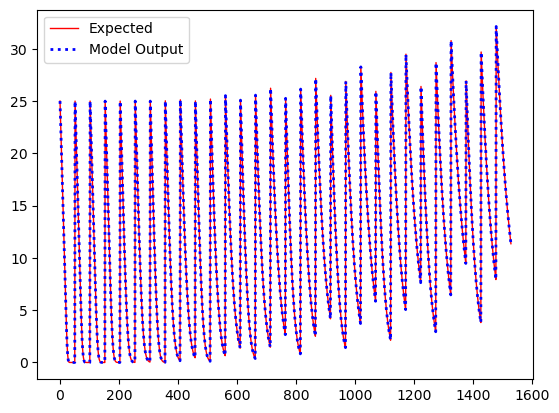

In [84]:
flatten = lambda x: list(map(lambda y: y[0], x))

plt.plot(df['OPRICE'], linewidth=1, color='red', label='Expected')
plt.plot(flatten(result), linewidth=2, color='blue', linestyle=':', label='Model Output')
plt.legend(loc="upper left")
plt.show()